# EP Model

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
import time
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

## Handling Field Goals

In [2]:
def FG_attempt(x):
    """Simulate whether a field goal gets taken given a state x in the
    form of a list, where item 0 is the Down, item 1 the field position,
    item 2 the yards to go, and item 3 the
    possession (-1 or 1). Return 0 for go for it and 1 for kick a field goal."""
    YTG = x[1]
    FP = x[2]
    log_odds = -0.13841007 - 0.01402377*FP - 1.03702422*YTG + 0.0168093*(YTG*FP)
    prob = np.exp(log_odds) / (1 + np.exp(log_odds))
    attempt = bernoulli.rvs(prob, 0)
    return bool(attempt)

In [3]:
def simulate_FG(x):
    """Simulate a field goal given a state x in the form of a list, where 
    item 0 is the Down, item 1 the field position,item 2 the yards to go,
    and item 3 the possession (-1 or 1).
    Return an updated state based on whether or not the field goal was 
    successful"""
    FP = x[2]
    POS = x[3]
    kick_length = 100 - FP + 17
    log_odds = 4.26788458 -0.08688154 * kick_length
    prob = np.exp(log_odds) / (1 + np.exp(log_odds))
    made = bernoulli.rvs(prob, 0)
    if made == 1:
        return [0, 0, 110, POS]
    else:
        return [1, 10, np.round(100 - (FP - 7), 2), POS*-1]

In [4]:
simulate_FG([4, 10, 80, 1])

[0, 0, 110, 1]

## Handling Punts & Returns

In [5]:
def punt_attempt(x):
    """Simulate whether a punt is attempted given a state x in the
    form of a list, where item 0 is the Down, item 1 the field position,
    item 2 the yards to go, and item 3 the
    possession (-1 or 1). Return 0 for go for it and 1 for punt."""
    YTG = x[1]
    FP = x[2]
    log_odds = 4.20181612 - 0.08861123*FP - 0.05904931*YTG + 0.00498547*(YTG*FP)
    prob = np.exp(log_odds) / (1 + np.exp(log_odds))
    attempt = bernoulli.rvs(prob, 0)
    return bool(attempt)

In [6]:
punt_depth = pd.read_csv("./punt_depth_distribution.csv")
punt_depth.columns = ['FP', 'MEAN', 'SD']
def simulate_punt(x, mod=0):
    """Simulate a punt given a state x in the form of a list, where 
    item 0 is the Down, item 1 the field position,item 2 the yards to go,
    and item 3 the possession (-1 or 1).
    Return an updated state based on how far the punt traveled and its return
    distance"""
    FP_ceil = ceil(x[2]/5) * 5
    FP = x[2]
    POS = x[3]
    #calculate punt depth
    row = punt_depth[punt_depth.FP == FP_ceil]
    kick_depth = np.random.normal(row.MEAN, row.SD)
    #check if touchback
    if FP + kick_depth > 100:
        return [1, 10, 25, POS*-1]
    #calculate punt hangtime
    hang_time = 1.8398441828383583 + 0.00831474*FP + 0.04157772*kick_depth + mod
    #calculate fair catch or not
    log_odds = -2.62774761 - 1.67618282*hang_time + 0.18391775*kick_depth
    prob = np.exp(log_odds) / (1 + np.exp(log_odds))
    fair = bernoulli.rvs(prob, 0)
    if fair == 0:
        return [1, 10, np.round(100 - (FP + kick_depth), 2), POS*-1]
    elif fair == 1:
        return_dist = np.exp(np.random.normal(3.09342, 0.395615))-16
        return [1, 10, np.round(100 - (FP + kick_depth - return_dist), 2), POS*-1]
    else:
        return "PUNT ERROR"

## Simulate Plays

In [7]:
lookup_df = pd.read_csv("./Probability_Lookup_Table.csv")
lookup_df = lookup_df.set_index(['Down', 'YTG', 'FP'])
def yards_gained(x, mod=0):
    """Simulate the yards gained via a mixture model given a state in the form of a list,
    where item 0 is the Down, item 1 the field position, item 2 the yards to go,
    and item 3 the possession (-1 or 1).
    Return an updated state based on a simulated yards gained"""
    D = x[0]
    YTG = x[1]
    if YTG <= 5:
        YTG = 0
    elif YTG > 5:
        YTG = 5
    FP = x[2]
    if FP < 25:
        FP = 0
    elif FP < 75:
        FP = 25
    else:
        FP = 75
    lookup_probs = lookup_df.loc[(D, YTG, FP)]
    play_call = np.random.choice(['Run', 'Short Pass', 'Long Pass'], size=1, replace=True,
                        p=[lookup_probs[0], lookup_probs[1], lookup_probs[2]])
    if play_call == 'Run':
        return np.random.standard_t(1.85069) * 2.94119 + 3.034
    elif play_call == 'Short Pass':
        catch = np.random.choice(['Complete', 'Incomplete', 'Interception'], size=1, replace=True, 
                                 p=[0.6268, 0.3554, 0.0178])
        if catch == 'Complete':
            return np.random.standard_t(3.15398) * 6.18355 + 7.13557
        elif catch == 'Incomplete':
            return 0
        elif catch == 'Interception':
            return 'Interception Short'
        else:
            return 'ERROR Short'
    else:
        catch = np.random.choice(['Complete', 'Incomplete', 'Interception'], size=1, replace=True,
                                 p=[0.36101499423298733, 0.5856978085351788, 0.05328719723183391])
        if catch == 'Complete':
            return np.exp(np.random.normal(3.4827, 0.363783))
        elif catch == 'Incomplete':
            return 0
        elif catch == 'Interception':
            return 'Interception Deep'
        else:
            return 'ERROR Deep'

In [8]:
def simulate_play(x, mod=0):
    """Simulate a play given a state x in the form of a list, where item
    0 is the Down, item 1 the field position, item 2 the yards to go, 
    and item 3 the possession (-1 or 1).
    Return an updated state based on a simulated yards gained"""
    gained = yards_gained(x, mod)
    D = x[0]
    YTG = x[1]
    FP = x[2]
    POS = x[3]
    
    if gained == 'Interception Short':
        FP += np.random.standard_t(3.15398) * 6.18355 + 7.13557
        return [1, 10, np.round(100 - FP, 2), -POS]
    elif gained == 'Interception Deep':
        FP += np.exp(np.random.normal(3.4827, 0.363783))
        return [1, 10, np.round(100 - FP, 2), -POS]
    
    FP = np.round(FP + gained, 2)
    YTG = np.round(YTG - gained, 2)
    
    if ((D == 4) and (x[2] >= 65)) and FG_attempt(x):
        #check if we're in a field goal state, simulate field goal
        return simulate_FG(x)
    elif ((D == 4) and (x[2] <= 60)) and punt_attempt(x):
        #check if we're in a field goal state, simulate field goal
        return simulate_punt(x, mod)
    elif FP >= 100:
        #check for a touchdown, if it's a touchdown return the touchdown state:
        return [0, 0, 100, POS]
    elif FP <= 0:
        #check for a safety, if it's a safety return the safety state:
        return [0, 0, 0, POS]
    elif YTG <= 0:
        #check for a first down, if it's a first down reset the down and yards to go
        D = 1
        YTG = 10
    elif D == 4:
        #turnover on downs, so change possession and switch the field position
        POS *= -1
        FP = np.round(100 - FP, 2)
        YTG = 10
        D = 1
    else:
        D += 1
        
    return [D, YTG, FP, POS]
    

In [9]:
simulate_play([3, 3, 30, 1])

[1, 10, 36.19, 1]

In [10]:
def simulate_football(D, YTG, FP, POS, mod=0):
    state = [D, YTG, FP, POS]
    state = simulate_play(state, mod)
    #while state is not a score, keep running plays but once in the score
    #state return 7 or -7 or 3 or -3
    while state[0] != 0:
        state = simulate_play(state, mod) 
    
    if state[2] == 100:
        return state[3] * 7
    elif state[2] == 110:
        return state[3] * 3
    elif state[2] == 0:
        return state[3] * 2
    

In [11]:
simulate_football(1, 10, 25, 1)

7

## Expected Points Calculation

In [12]:
def expected_points(state, reps, mod=0):
    scores = []
    D = state[0]
    YTG = state[1]
    FP = state[2]
    POS = state[3]
    for i in range(reps):
        score = simulate_football(D, YTG, FP, POS, mod)
        scores.append(score)

    return np.mean(scores)

In [13]:
expected_points([1, 10, 25, 1], 100)

1.16

In [14]:
def ep_model(Downs, YTGs, FPs, n, m=0):
    ep_df = pd.DataFrame()
    for d in Downs:
        for y in YTGs:
            for f in FPs:
                ep_points = expected_points([d, y, f, 1], n, m)
                ep = pd.DataFrame([[d, y, f, ep_points]])
                ep_df = pd.concat([ep_df, ep])
    ep_df.columns = ['Down', 'YTG', 'FP', 'EP']
    return ep_df.reset_index().drop('index', axis=1)

## Calculate Expected Points with Different Run & Pass Distributions, and create Graphical Outputs

In [15]:
#.6528530130391946/2 is chosen because it is half the standard deviation of punt hangtime.
#That means we are analyzing punters half a standard deviation above the mean and half a standard
#deviation below in terms of hangtime
start = time.time()
cpu_start = time.process_time()
ep_table_normal = ep_model([1, 2, 3, 4], [2, 5, 10, 15], [10, 20, 30, 40, 50, 60, 70, 80, 90], 10000)
ep_table_hang = ep_model([1, 2, 3, 4], [2, 5, 10, 15], [10, 20, 30, 40, 50, 60, 70, 80, 90], 10000, .6528530130391946/2)
ep_table_fall = ep_model([1, 2, 3, 4], [2, 5, 10, 15], [10, 20, 30, 40, 50, 60, 70, 80, 90], 10000, -.6528530130391946/2)
cpu_end = time.process_time()
end = time.time()
elapsed_time = end - start
cpu_time = cpu_end - cpu_start
print('CPU time:', cpu_time, 'seconds')
print('Execution time:', elapsed_time, 'seconds')
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 360 seconds for n=100
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 3150 seconds (52.5 minutes) for n=1000
#all 4 downs, [2, 5, 10, 15], fp every 10 takes about 10.6 hours for n=10000

CPU time: 38099.832822 seconds
Execution time: 38328.06593418121 seconds


In [16]:
ep_table_difference = ep_table_normal[['Down', 'YTG', 'FP']]
ep_table_difference['EP_Difference_Increase_Hang'] = ep_table_normal['EP'] - ep_table_hang['EP']
ep_table_difference['EP_Difference_Decrease_Hang'] = ep_table_normal['EP'] - ep_table_fall['EP']
ep_table_difference['EP_Difference_Increase-Decrease'] = ep_table_hang['EP'] - ep_table_fall['EP']
ep_table_difference

,Down,YTG,FP,EP_Difference_Increase_Hang,EP_Difference_Decrease_Hang,EP_Difference_Increase-Decrease
0,1,2,10,0.0125,0.0103,-0.0022
1,1,2,20,-0.0767,-0.1082,-0.0315
2,1,2,30,0.0068,-0.0435,-0.0503
3,1,2,40,-0.0071,0.0118,0.0189
4,1,2,50,-0.0855,0.0349,0.1204
...,...,...,...,...,...,...
139,4,15,50,0.0877,0.0815,-0.0062
140,4,15,60,-0.0729,-0.1844,-0.1115
141,4,15,70,-0.0100,-0.0365,-0.0265
142,4,15,80,-0.0110,-0.0316,-0.0206


In [17]:
ep_table_difference.to_csv('EP Difference Table.csv')
print(ep_table_difference['EP_Difference_Increase_Hang'].mean())
print(ep_table_difference['EP_Difference_Increase_Hang'].median())
print(ep_table_difference['EP_Difference_Decrease_Hang'].mean())
print(ep_table_difference['EP_Difference_Decrease_Hang'].median())

0.002128472222222221
0.006899999999999962
0.006361111111111116
0.010699999999999953


In [26]:
minv = ep_table_difference['EP_Difference_Increase-Decrease'].min()
maxv = ep_table_difference['EP_Difference_Increase-Decrease'].max()
scale = ceil(max(abs(minv), abs(maxv)))
scale = .3
scale

0.3

[Text(0.5, 1.0, '4th Down')]

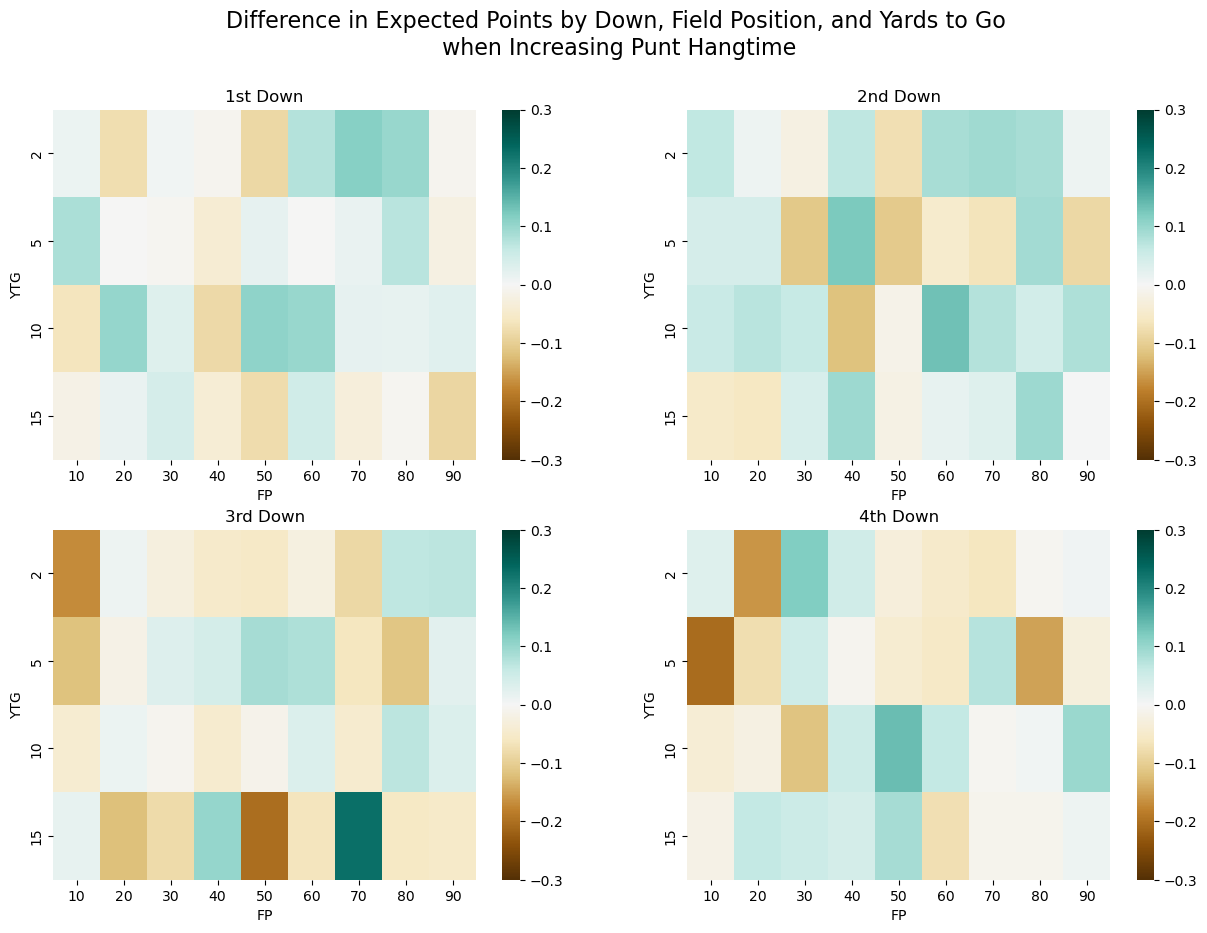

In [27]:
def ep_df_format(df, down, col):
    """Input a dataframe, the down, and a column, output the filtered df with
    the associated values for the chosen column"""
    return df[df['Down']==down].pivot(index="YTG", columns='FP', values=col)

fig1, axes1 = plt.subplots(2, 2, figsize=[15, 10])
fig1.suptitle('Difference in Expected Points by Down, Field Position, and Yards to Go\n when Increasing Punt Hangtime', fontsize=16)
sns.heatmap(ep_df_format(ep_table_difference, 1, 'EP_Difference_Increase_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes1[0,0]).set(title='1st Down')
sns.heatmap(ep_df_format(ep_table_difference, 2, 'EP_Difference_Increase_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes1[0,1]).set(title='2nd Down')
sns.heatmap(ep_df_format(ep_table_difference, 3, 'EP_Difference_Increase_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes1[1,0]).set(title='3rd Down')
sns.heatmap(ep_df_format(ep_table_difference, 4, 'EP_Difference_Increase_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes1[1,1]).set(title='4th Down')


[Text(0.5, 1.0, '4th Down')]

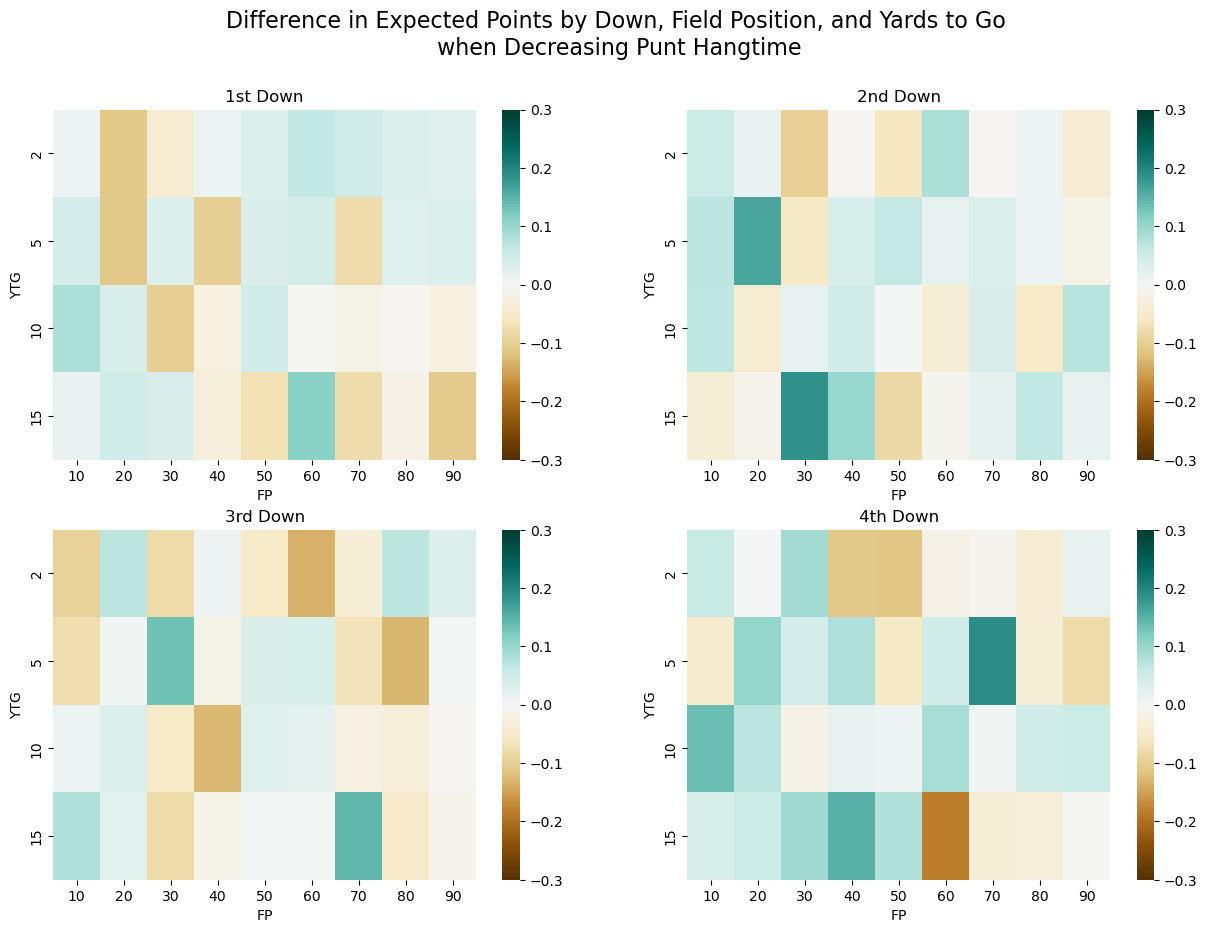

In [28]:
fig2, axes2 = plt.subplots(2, 2, figsize=[15, 10])
fig2.suptitle('Difference in Expected Points by Down, Field Position, and Yards to Go\n when Decreasing Punt Hangtime', fontsize=16)
sns.heatmap(ep_df_format(ep_table_difference, 1, 'EP_Difference_Decrease_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes2[0,0]).set(title='1st Down')
sns.heatmap(ep_df_format(ep_table_difference, 2, 'EP_Difference_Decrease_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes2[0,1]).set(title='2nd Down')
sns.heatmap(ep_df_format(ep_table_difference, 3, 'EP_Difference_Decrease_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes2[1,0]).set(title='3rd Down')
sns.heatmap(ep_df_format(ep_table_difference, 4, 'EP_Difference_Decrease_Hang'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes2[1,1]).set(title='4th Down')


<AxesSubplot: ylabel='Count'>

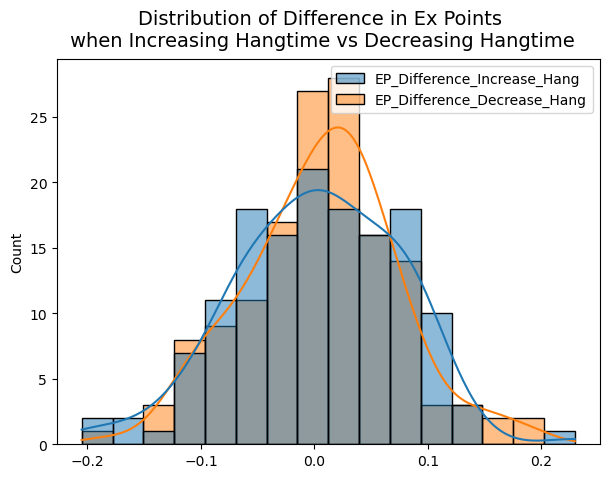

In [29]:
fig3, axes3 = plt.subplots(1, 1, figsize=[7, 5])
fig3.suptitle('Distribution of Difference in Ex Points\n when Increasing Hangtime vs Decreasing Hangtime', fontsize=14)
sns.histplot(ep_table_difference[['EP_Difference_Increase_Hang','EP_Difference_Decrease_Hang']], kde=True,
                   ax=axes3)

[Text(0.5, 1.0, '4th Down')]

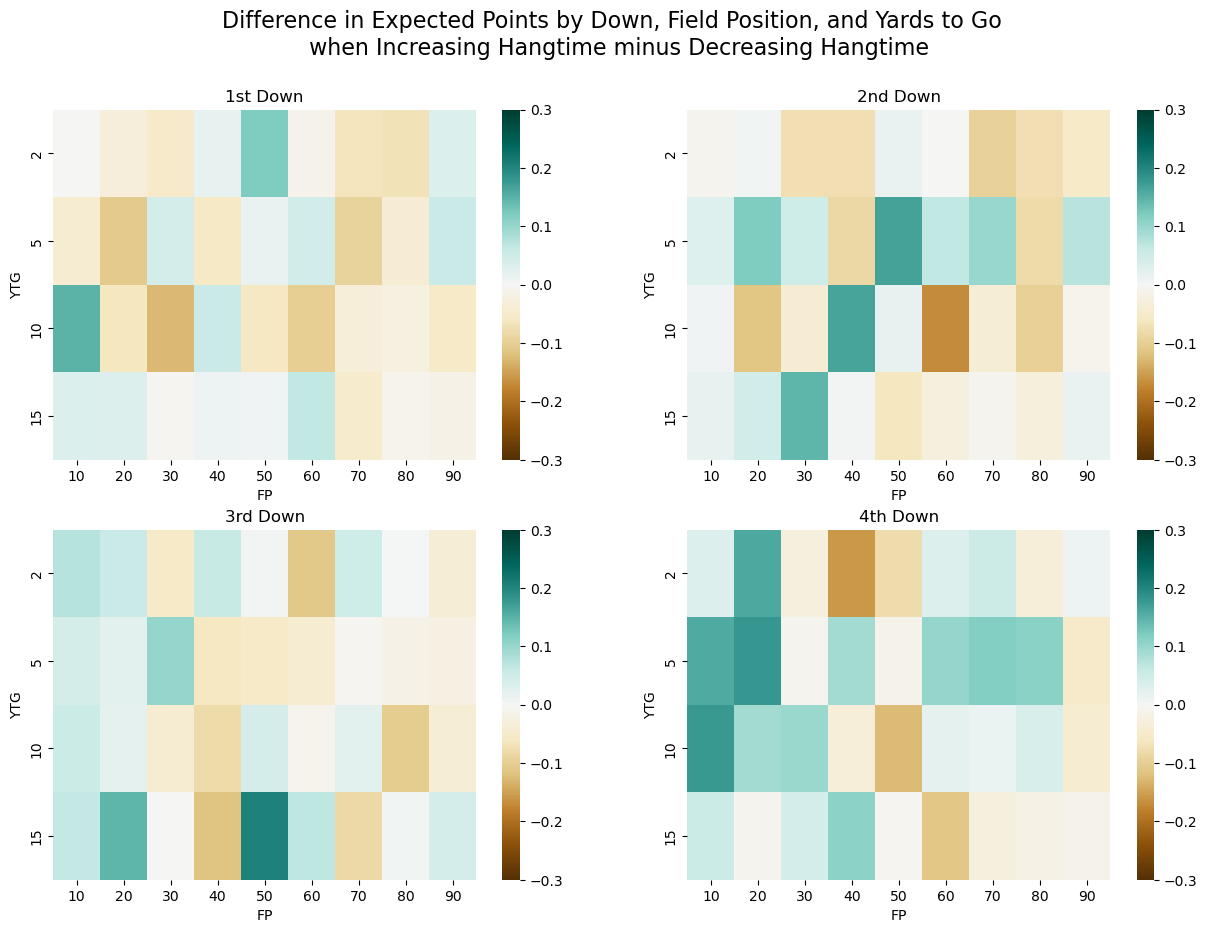

In [30]:
fig4, axes4 = plt.subplots(2, 2, figsize=[15, 10])
fig4.suptitle('Difference in Expected Points by Down, Field Position, and Yards to Go \n when Increasing Hangtime minus Decreasing Hangtime', fontsize=16)
sns.heatmap(ep_df_format(ep_table_difference, 1, 'EP_Difference_Increase-Decrease'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes4[0,0]).set(title='1st Down')
sns.heatmap(ep_df_format(ep_table_difference, 2, 'EP_Difference_Increase-Decrease'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes4[0,1]).set(title='2nd Down')
sns.heatmap(ep_df_format(ep_table_difference, 3, 'EP_Difference_Increase-Decrease'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes4[1,0]).set(title='3rd Down')
sns.heatmap(ep_df_format(ep_table_difference, 4, 'EP_Difference_Increase-Decrease'),
            vmin=-scale, vmax=scale, cmap='BrBG', ax=axes4[1,1]).set(title='4th Down')

In [31]:
#Save the graphs
fig1.savefig('EP Increase Hangtime Visualization.png', dpi=400)
fig2.savefig('EP Decrease Hangtime Visualization.png', dpi=400)
fig3.savefig('EP Increase-Decrease Histogram.png', dpi=400)
fig4.savefig('EP Increase-Decrease Heatmap.png', dpi=400)